# Soft-VAE

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from datetime import datetime

%matplotlib inline

### Parameters

In [4]:
dataset_path = '/pio/lscratch/1/i279076/Medical/small-medical-22.h5'
batch_size = 1024
num_workers = 4
z_dim = 100
lr = 0.001
log_interval = 50
epochs = 5
save_model = True

name = 'Soft-VAE'

### Data loader

In [5]:
import h5py

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [6]:
class SmallMedicalDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label


class SmallMedicalLoader:
    def __init__(self, dataset_path, batch_size, num_workers=8, pin_memory=True):
        self.dataset_path = dataset_path
        self.loader_args = dict(batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory)

        with h5py.File(self.dataset_path, 'r') as f:
            self.train_images = f['train']['images'][...]
            self.train_labels = f['train']['labels'][...]

            self.test_images = f['test']['images'][...]
            self.test_labels = f['test']['labels'][...]

        self.train_dataset = SmallMedicalDataset(self.train_images, self.train_labels)
        self.test_dataset = SmallMedicalDataset(self.test_images, self.test_labels)

    def train_loader(self):
        return DataLoader(self.train_dataset, **self.loader_args)

    def test_loader(self):
        return DataLoader(self.test_dataset, shuffle=True, **self.loader_args)
    
    def test_loader_no_shfl(self):
        return DataLoader(self.test_dataset, shuffle=False, **self.loader_args)

In [7]:
loader = SmallMedicalLoader(dataset_path, batch_size)

train_loader = loader.train_loader()
test_loader = loader.test_loader()
test_loader_no_shfl = loader.test_loader_no_shfl()

### Model prototype

In [8]:
class PrototypeSVAE(nn.Module):
    def __init__(self, z_dim=60):
        super().__init__()

        self.z_dim = z_dim

        self.fc1  = nn.Linear(22**2, 400)
        self.fc21 = nn.Linear(400, self.z_dim)
        self.fc22 = nn.Linear(400, self.z_dim)
        self.fc3  = nn.Linear(self.z_dim, 400)
        self.fc4  = nn.Linear(400, 256 * 22**2)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        out = F.log_softmax(self.fc4(h3).reshape(-1, 256, 22, 22), dim=1)
        return out

    def forward(self, x):
        x = x[:, 1, :, :].view(-1, 22**2)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def NLL_loss(self, x, recon_x):
        return F.nll_loss(recon_x, (255 * x[:, 1, :, :]).long(), reduction='none').reshape(-1, 22 ** 2)
    
    def MSE_loss(self, x, recon_x):
        x = x[:, 1, :, :].reshape(-1, 22**2)
        return ((x - recon_x) ** 2)
    
    def KLD_loss(self, mu, logvar):
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        return (-0.5 * (1 + logvar - mu.pow(2) - logvar.exp()))
    
    def loss_function(self, x, recon_x, mu, logvar, extended=False):
        NLL = self.NLL_loss(x, recon_x).sum(1)
        KLD = self.KLD_loss(mu, logvar).sum(1)

        loss = NLL.sum() + KLD.sum()
        return (loss, NLL, KLD) if extended else loss

#### Test function

In [9]:
def test_epoch(epoch):
    model.eval()
    
    samples = len(test_loader.dataset)
    X, Y = np.zeros((2, samples)), np.zeros(samples)

    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            data = data.cuda()

            recon_data, mu, logvar = model(data)
            _, mse, kld = model.loss_function(data, recon_data, mu, logvar, extended=True)

            X[:, i * batch_size : i * batch_size + len(data)] = torch.stack([mse, kld]).cpu()
            Y[i * batch_size : i * batch_size + len(data)] = labels
            
    fig = plt.figure(figsize=(14,7))
    gs = gridspec.GridSpec(5, 5)

    ax_main = plt.subplot(gs[1:3, :4])
    ax_xDist = plt.subplot(gs[0, :4], sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:3, 4], sharey=ax_main)

    for i, label in [(0, 'negative'), (1, 'positive')]:
        indices = (Y == i).nonzero()
        x, y = X[:, indices].squeeze()
        ax_main.scatter(x, y, s=2, alpha=0.7, label=label)
        ax_xDist.hist(x, bins=100, histtype='step')
        ax_yDist.hist(y, bins=100, orientation='horizontal', histtype='step')

    ax_main.set(xlabel="NLL", ylabel="KLD", title=f'Compare losses for labeled images on epoch: {epoch}')
    ax_main.legend()
    
    cum_loss = X.sum(0)

    ax_roc = plt.subplot(gs[3:5, 4])
    fpr, tpr, thresholds = roc_curve(Y, cum_loss)
    if auc(fpr, tpr) < 0.5:
        fpr, tpr, thresholds = roc_curve(Y, cum_loss, pos_label=0)
        
    area = auc(fpr, tpr)
    
    ax_roc.plot(fpr, tpr)
    ax_roc.plot([0, 1], [0, 1], linestyle='--')

    ax_roc.set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC (area = {:.2f})'.format(area))
    ax_roc.set_aspect('equal')
    
    ax_gen = plt.subplot(gs[3:5, :4])
    
    with torch.no_grad():
        for data, _ in test_loader:
            recon, _, _ = model(data.cuda())
            recon = recon.max(1)[1]
            recon = recon.cpu().reshape(-1, 22, 22)
            recon = recon.float() / 255.

            merged = torch.cat([data[:, 1, :, :], recon], 2)
        
    samples = merged[:24]
    samples = samples.reshape(8, 22 * 3, 44)
    samples = samples.permute(1, 0, 2).reshape(-1, 8 * 44)
    
    ax_gen.imshow(samples)
    ax_gen.axis('off')

    plt.tight_layout()
    plt.show()

#### Training

In [10]:
model = PrototypeSVAE(z_dim=z_dim).cuda()

optimizer = optim.Adam(model.parameters(), lr=lr)

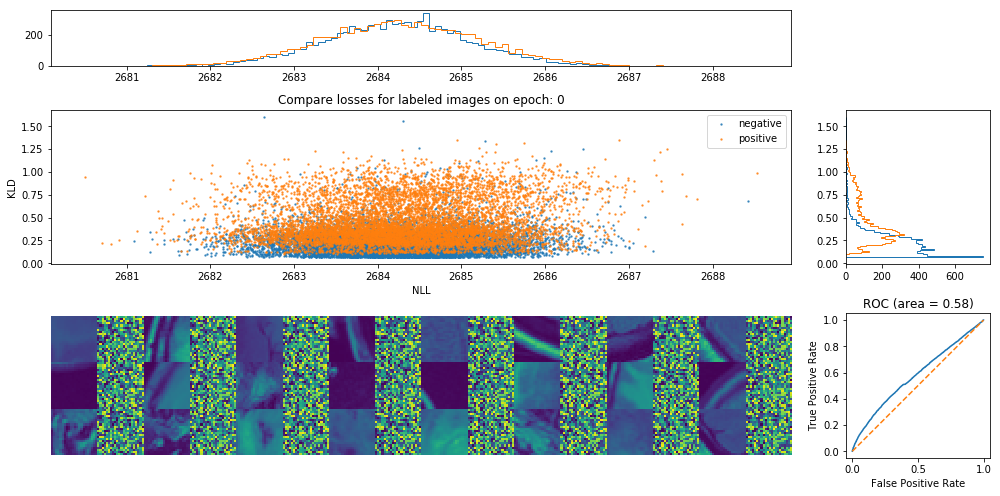

Epoch: 1


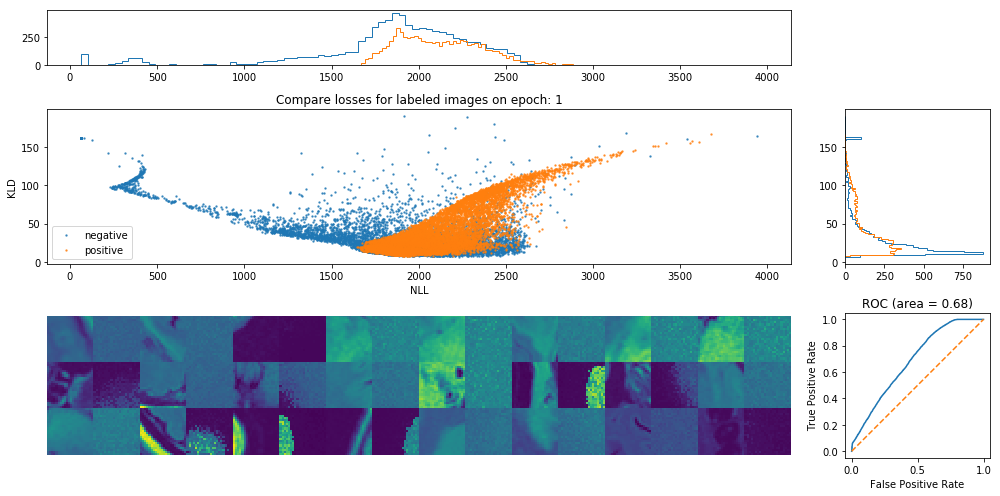

Epoch: 2


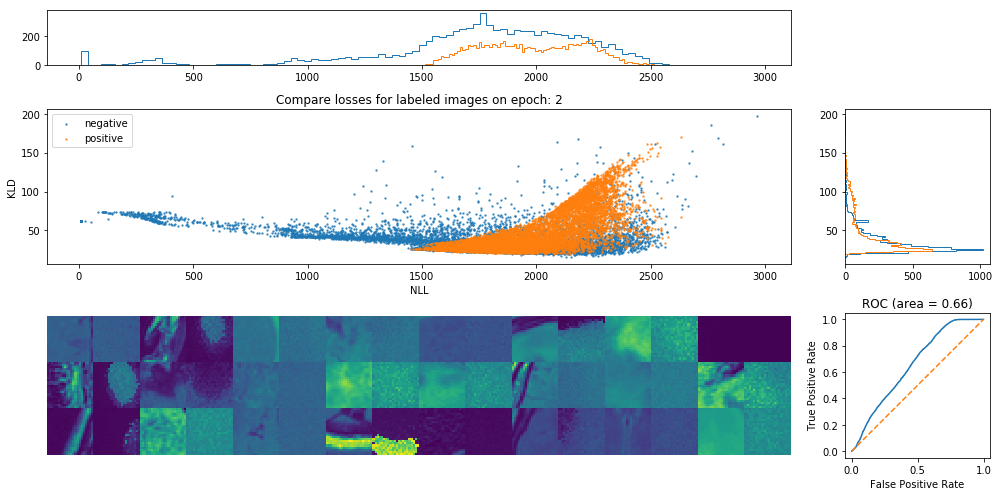

Epoch: 3


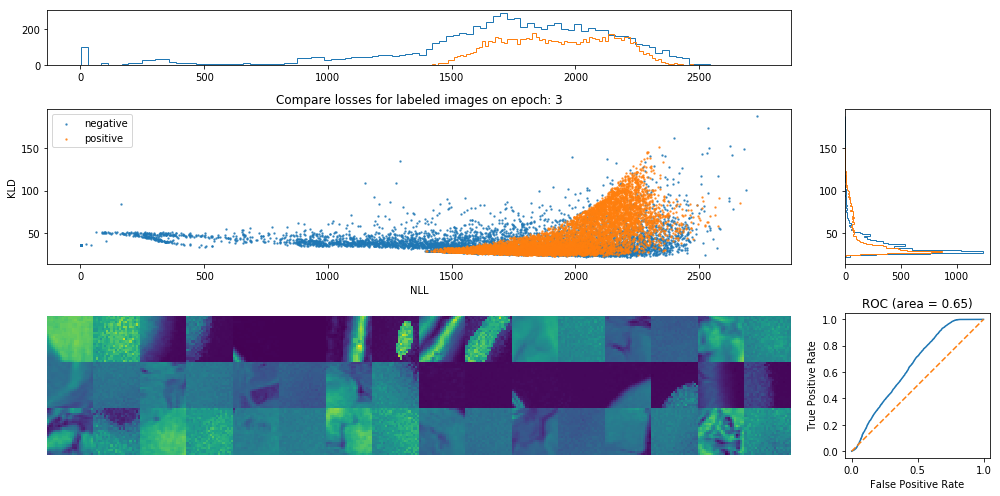

Epoch: 4


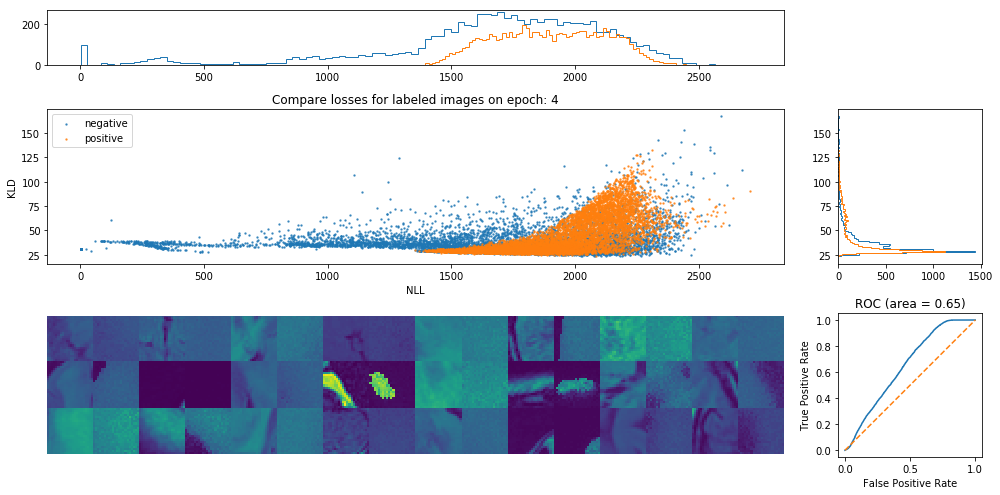

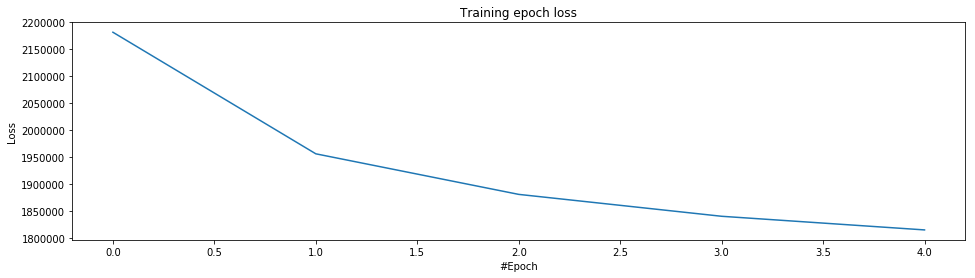

In [11]:
model.train()

test_epoch(0)
losses = []

for epoch in range(1, epochs + 1):
    train_loss = 0.
    
    for i, (data, _) in enumerate(train_loader):
        model.train()
        data = data.cuda()
        
        optimizer.zero_grad()

        recon_data, mu, logvar = model(data)

        loss, mse, kld = model.loss_function(data, recon_data, mu, logvar, extended=True)
        loss.backward()

        optimizer.step()
        
        train_loss += loss.item()
        
    losses.append(train_loss / len(train_loader))
    
    if epoch < 5 or epoch % 20 == 0:
        print(f'Epoch: {epoch}')
        test_epoch(epoch)
        if save_model:
            torch.save(model.state_dict(), 'checkpoints/model_{}_{}.pth'.format(name, epoch))
        
model.eval()

plt.figure(figsize=(16, 4))
plt.plot(losses)
plt.title('Training epoch loss')
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.show()